In [1]:

import os
import locale
from enum import Enum

import pandas as pd 
import numpy as np 

from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

class ModelType(Enum):
    LOGISTIC = 1
    EXPONENTIAL = 2

locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=en_US.UTF-8;LC_NUMERIC=it_IT.UTF-8;LC_TIME=it_IT.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=it_IT.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=it_IT.UTF-8;LC_NAME=it_IT.UTF-8;LC_ADDRESS=it_IT.UTF-8;LC_TELEPHONE=it_IT.UTF-8;LC_MEASUREMENT=it_IT.UTF-8;LC_IDENTIFICATION=it_IT.UTF-8'

In [2]:
# Data file to be read:
data_file_path = os.path.join("..","data")
it_data_file_name = "virus-it.csv"
lo_data_file_name = "virus-lombardia.csv"
it_data_file = os.path.join(data_file_path, it_data_file_name)
lo_data_file = os.path.join(data_file_path, lo_data_file_name)

# Place where images are saved:
images_path = os.path.join("..","images")

# Training data for the model: the number of samples used for
# the model training.
training_data_end = 23

In [3]:
#
# Load Italian dataset.
#
df = pd.read_csv(it_data_file, sep=',', lineterminator='\n'
                ,low_memory=False)

df["timeStamp"] = pd.to_datetime(df["Data"], format="%d/%m/%Y")
df.sort_values(by=["timeStamp"], inplace=True)

min_date = df['timeStamp'].min()
df['TimeDelta'] = (df['timeStamp'] - min_date).dt.days + 1
df["TotalDiff"] = df["Totale"].diff(periods = 1)
#df["GrowthFactor"] = df["TotalDiff"].pct_change()

all_deaths = df["Morti"].max()
all_infected = df["Totale"].max()
it_infected_deaths_ratio = round((all_deaths / all_infected) * 100, 1)

(df.shape, df.dtypes)

((26, 8),
 Data                    object
 Casi attuali             int64
 Morti                    int64
 Guariti                  int64
 Totale                   int64
 timeStamp       datetime64[ns]
 TimeDelta                int64
 TotalDiff              float64
 dtype: object)

In [4]:
#
# Load Lombardy dataset.
#
df_lo = pd.read_csv(lo_data_file, sep=',', lineterminator='\n', low_memory=False)

df_lo["timeStamp"] = pd.to_datetime(df_lo["Data"], format="%d/%m/%Y")
df_lo.sort_values(by=["timeStamp"], inplace=True)

min_date = df_lo['timeStamp'].min()
df_lo['TimeDelta'] = (df_lo['timeStamp'] - min_date).dt.days + 1
df_lo["TotalDiff"] = df_lo["Totale"].diff(periods = 1)

(df.shape, df.dtypes)

((26, 8),
 Data                    object
 Casi attuali             int64
 Morti                    int64
 Guariti                  int64
 Totale                   int64
 timeStamp       datetime64[ns]
 TimeDelta                int64
 TotalDiff              float64
 dtype: object)

In [5]:
df.head(30)

,Data,Casi attuali,Morti,Guariti,Totale,timeStamp,TimeDelta,TotalDiff
25,01/03/2020,1577,34,83,1694,2020-03-01,1,NaN
24,02/03/2020,1835,52,149,2036,2020-03-02,2,342.0
23,03/03/2020,2263,79,160,2502,2020-03-03,3,466.0
22,04/03/2020,2706,107,276,3089,2020-03-04,4,587.0
21,05/03/2020,3296,148,414,3858,2020-03-05,5,769.0
20,06/03/2020,3916,197,523,4636,2020-03-06,6,778.0
19,07/03/2020,5061,233,589,5883,2020-03-07,7,1247.0
18,08/03/2020,6387,366,622,7375,2020-03-08,8,1492.0
17,09/03/2020,7985,463,724,9172,2020-03-09,9,1797.0
16,10/03/2020,8514,631,1004,10149,2020-03-10,10,977.0


In [6]:
df_lo.head(2)

,Data,Ricoverati con sintomi,Terapia intensiva,Isolamento domiciliare,Totale positivi,Dimessi,Deceduti,Totale,Tamponi,timeStamp,TimeDelta,TotalDiff
25,01/03/2020,406,106,375,887,73,24,984,6879,2020-03-01,1,NaN
24,02/03/2020,478,127,472,1077,139,38,1254,7925,2020-03-02,2,270.0


In [7]:
# ------------------------------------------------------------
# ------------------------------------------------------------
# Some common functions.
# ------------------------------------------------------------
# ------------------------------------------------------------
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False, border=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(border)
        axe.spines['left'].set_visible(border)
        axe.spines['right'].set_visible(border)
        axe.spines['bottom'].set_visible(border)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

def text_box(ax, text, colors=["#FFFFFF", "#000000"], fontsize=14, x=0, y=0):
    """
    """
    rv = False
    try:
        edgecolor = "none"
        boxstyle = "square"
        if len(colors) >= 3 and colors[2] is not None:
            edgecolor = colors[2]
            boxstyle = "round,pad=1"
        ax.text(x, y
               ,text
               ,ha="left", va="center" 
               ,bbox=dict(boxstyle = boxstyle, facecolor = colors[0], edgecolor = edgecolor)
               ,color=colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, no_grid=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv   

In [8]:
#----------------------------------------------------------------
#
#----------------------------------------------------------------
def c_virus_chart(ax, x, y, colors=["#0000e6", "#727170"],log=False, title=None):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, no_grid=False)
        #ax.set_xlim(time_limits)

        time_limits = [x.min() - pd.Timedelta(hours=10) 
                      ,x.max() + pd.Timedelta(hours=10)]
        ax.set_xlim(time_limits)
        
        if log == True:
            ax.set_yscale('log')
            ax.set_ylabel("Numero - scala logaritmica", fontsize=12)
        else:
            ax.set_ylabel("Numero", fontsize=12)
            if title is not None:
                ax.set_title(title, fontsize=16)
            else:
                ax.set_title("Progressione contagio COVID-19", fontsize=16)
    
        ax.scatter(x, y, color=colors[0], s=7)
        ax.plot(x, y, 'b-', linewidth=1.0, color=colors[1], label="Totale casi")
        
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        ax.legend(fontsize=12, loc='lower right')
            
    except Exception as ex:
        print("c_virus_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv

#----------------------------------------------------------------
#
#----------------------------------------------------------------
def composed_c_virus_chart(ax, data_sets,log=False, title=None):
    """
    
    :param ax:
    :param data_sts:
    :param log:
    :param title:
    :return:
    """
    rv = False
    try:
        set_axes_common_properties(ax, no_grid=False)
        #ax.set_xlim(time_limits)

        max_y = None
        for key in data_sets.keys():
            df = data_sets[key]["df"]
            x = df["timeStamp"].dt.to_pydatetime()
            
            if data_sets[key].get("value column") is not None:
                col_name = data_sets[key]["value column"]
                y = df[col_name]
            else:
                y = df["Totale"]
            new_max = y.max()
            if max_y is None or new_max > max_y:
                max_y = new_max
                
            colors = data_sets[key]["colors"]

            time_limits = [x.min() - pd.Timedelta(hours=10) 
                          ,x.max() + pd.Timedelta(hours=10)]
            ax.set_xlim(time_limits)
            
            ax.scatter(x, y, color=colors[0], s=data_sets[key]["size"], marker=data_sets[key]["dot-shape"], label=data_sets[key]["label"])
            if data_sets[key]["no_plot"] == False:
                ax.plot(x, y, 'b-', linewidth=data_sets[key]["line-size"], color=colors[1])
        
        if title is not None:
            ax.set_title(title, fontsize=16)
        
        ax.set_ylim(top=max_y + 1000)
        
        ax.set_ylabel("Numero", fontsize=12)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        # 'upper left' - 'upper right' - 'lower right'
        ax.legend(fontsize=12, loc='upper left')
            
    except Exception as ex:
        print("composed_c_virus_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv

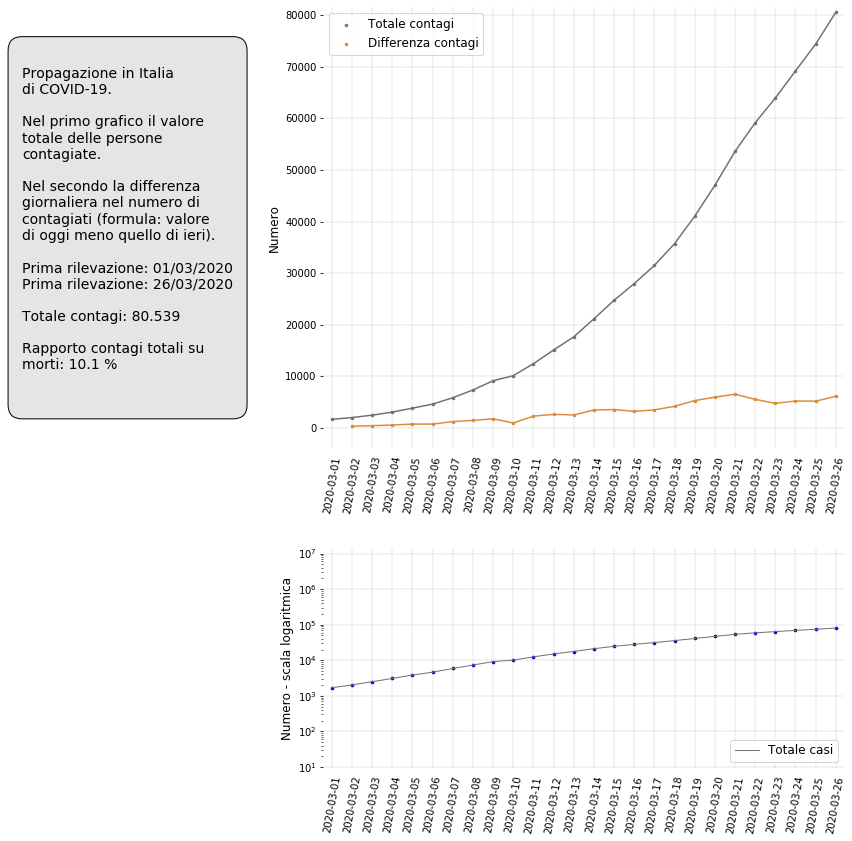

In [9]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df["timeStamp"].min().strftime(date_format)
max_date = df["timeStamp"].max().strftime(date_format)
total = f'{df["Totale"].max():n}'

df_total_diff = df[["timeStamp", "TotalDiff"]]

data_sets = {
    "Italy": {
        "df": df,
        "label": "Totale contagi",
        "colors": ["#727170", "#727170"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "TotalDiff": {
        "df": df_total_diff,
        "value column": "TotalDiff",
        "label": "Differenza contagi",
        "colors": ["#db8c3c", "#db8c3c"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}
# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 14))
gs1 = gridspec.GridSpec(2, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5 
                       ,width_ratios=[2, 7]
                       ,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Italia
di COVID-19.

Nel primo grafico il valore
totale delle persone 
contagiate.

Nel secondo la differenza
giornaliera nel numero di
contagiati (formula: valore
di oggi meno quello di ieri).

Prima rilevazione: {d1}
Prima rilevazione: {d2}

Totale contagi: {t}

Rapporto contagi totali su
morti: {idr} %

""".format(d1=min_date, d2=max_date
          ,t=total
          ,idr=it_infected_deaths_ratio)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.5)

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
#c_virus_chart(ax[idx],x=x, y=df["Totale"])
composed_c_virus_chart(ax[idx], data_sets)

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
c_virus_chart(ax[idx],x=x, y=df["Totale"],log=True, title="COVID-19 - Totale contagi giornalieri in Italia")

plt.savefig(os.path.join(images_path,"covid19_chart.png"))


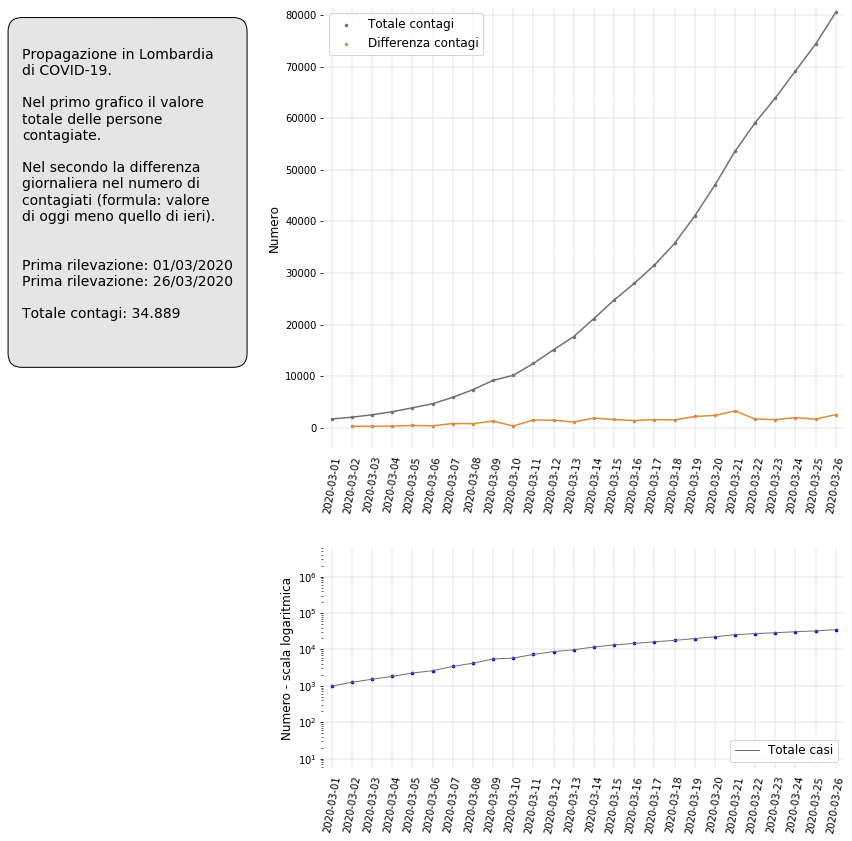

In [10]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

df_total_diff = df_lo[["timeStamp", "TotalDiff"]]

data_sets = {
    "Lombardy": {
        "df": df,
        "label": "Totale contagi",
        "colors": ["#727170", "#727170"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "TotalDiff": {
        "df": df_total_diff,
        "value column": "TotalDiff",
        "label": "Differenza contagi",
        "colors": ["#db8c3c", "#db8c3c"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}

# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 14))
gs1 = gridspec.GridSpec(2, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5 
                       ,width_ratios=[2, 7]
                       ,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Lombardia
di COVID-19.

Nel primo grafico il valore
totale delle persone 
contagiate.

Nel secondo la differenza
giornaliera nel numero di
contagiati (formula: valore
di oggi meno quello di ieri).


Prima rilevazione: {d1}
Prima rilevazione: {d2}

Totale contagi: {t}

""".format(d1=min_date, d2=max_date
          ,t=total)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.58)

idx += 1
x = df_lo["timeStamp"].dt.to_pydatetime()
composed_c_virus_chart(ax[idx], data_sets)
#c_virus_chart(ax[idx],x=x, y=df_lo["Totale"], title="LOMBARDIA - Progressione contagio COVID-19")

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
c_virus_chart(ax[idx],x=x, y=df_lo["Totale"],log=True)

plt.savefig(os.path.join(images_path,"covid19_lombardy_chart.png"))


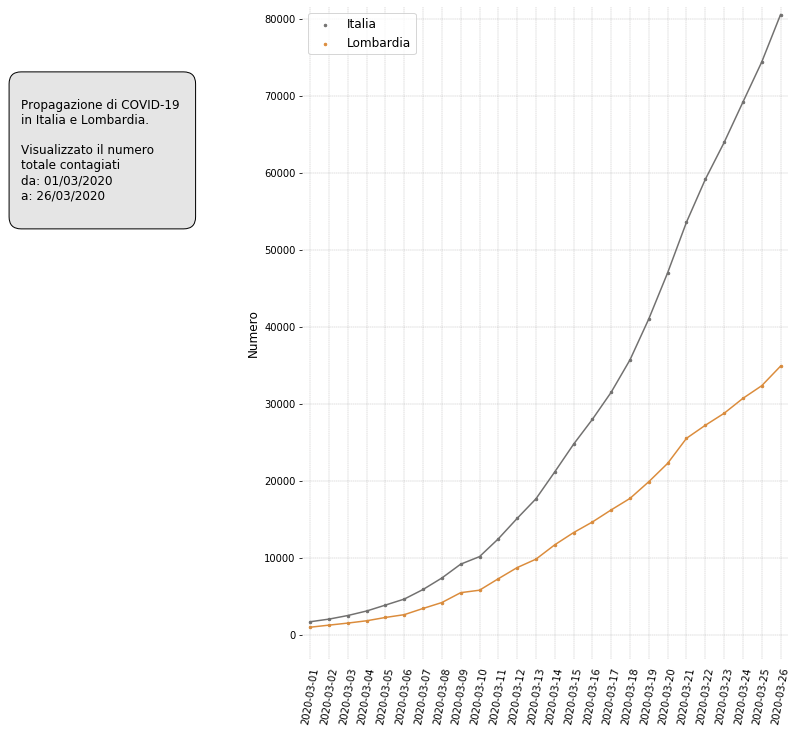

In [11]:
# ------------------------------------------------------
# Data preparation.
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

data_sets = {
    "Italy": {
        "df": df,
        "label": "Italia",
        "colors": ["#727170", "#727170"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "Lombardy": {
        "df": df_lo,
        "label": "Lombardia",
        "colors": ["#db8c3c", "#db8c3c"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}
# ------------------------------------------------------
# Chart
# ------------------------------------------------------
fig = plt.figure(figsize=(14, 12))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5 
                       ,width_ratios=[2, 7])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))

idx = 0
text = """
Propagazione di COVID-19 
in Italia e Lombardia.

Visualizzato il numero 
totale contagiati 
da: {mid} 
a: {mad}
""".format(mid=min_date, mad=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.78, fontsize=12)

idx += 1
x = df_lo["timeStamp"].dt.to_pydatetime()
composed_c_virus_chart(ax[idx], data_sets)

plt.savefig(os.path.join(images_path,"covid19_composed_chart.png"))


In [12]:
# ------------------------------------------------------------
# Model fitting functions
# ------------------------------------------------------------

# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
    
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def get_fitted_model_params(df, x_index, y_index
                           ,p0_estimate, function
                           ,training_data_end=training_data_end):
    """
    
    """
    model_params = None
    try:
        df_temp = df.copy()
        df_temp.dropna(inplace=True)
        #dates = list(df.iloc[:,5])
        y = list(df_temp.iloc[:training_data_end, y_index])
        x = list(df_temp.iloc[:training_data_end, x_index])
        model_params = curve_fit(function, x, y, p0=p0_estimate)
        
    except Exception as ex:
        print("get_fitted_model_params failed - {ex}".format(ex=ex))
    return model_params

#
# Fitting parameters.
#
def calculate_model_parameters(training_data_end):
    result = None
    try:
        x_index = list(df.columns).index('TimeDelta')
        y_index = list(df.columns).index('Totale')
        it_log_fit = get_fitted_model_params(df, x_index=x_index, y_index=y_index
                                             ,p0_estimate=[2,50,100000]
                                             ,function=logistic_model
                                             ,training_data_end=training_data_end)

        x_index = list(df_lo.columns).index('TimeDelta')
        y_index = list(df_lo.columns).index('Totale')
        lom_log_fit = get_fitted_model_params(df_lo, x_index=x_index, y_index=y_index
                                             ,p0_estimate=[2,50,80000]
                                             ,function=logistic_model
                                             ,training_data_end=training_data_end)

        a = it_log_fit[0][0]
        b = it_log_fit[0][1]
        c = it_log_fit[0][2]
        
        a_lom = lom_log_fit[0][0]
        b_lom = lom_log_fit[0][1]
        c_lom = lom_log_fit[0][2]

        # Epidemy end.
        sol_it = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b))
        sol_lom = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c_lom), b_lom))
        
        result = (it_log_fit, lom_log_fit, sol_it, sol_lom)

    except Exception as ex:
        print("calculate_model_parameters failed - {ex}".format(ex=ex))
    return result


In [13]:
# ------------------------------------------------------------
# Model fitting
# ------------------------------------------------------------

model_params = calculate_model_parameters(training_data_end=training_data_end)
if model_params is None:
    assert False, "Model fitting failed."
    
it_log_fit, lom_log_fit, sol_it, sol_lom = model_params

a = it_log_fit[0][0]
b = it_log_fit[0][1]
c = it_log_fit[0][2]
a_lom = lom_log_fit[0][0]
b_lom = lom_log_fit[0][1]
c_lom = lom_log_fit[0][2]

("a",f'{a:.2f}', "b", f'{b:.2f}', "c", f'{c:.2f}', it_log_fit,
 "a lom", f'{a_lom:.2f}', "b lom", f'{b_lom:.2f}', "c_lom", f'{c_lom:.2f}', lom_log_fit,
 "End of epidemy (IT):", sol_it, "End of epidemy (LOM):", sol_lom)


('a',
 '5.17',
 'b',
 '22.02',
 'c',
 '116925.69',
 (array([5.16916164e+00, 2.20175961e+01, 1.16925689e+05]),
  array([[1.15249298e-02, 4.04556542e-02, 4.47416599e+02],
         [4.04556542e-02, 1.60773245e-01, 1.80617125e+03],
         [4.47416599e+02, 1.80617125e+03, 2.05037311e+07]])),
 'a lom',
 '5.30',
 'b lom',
 '19.89',
 'c_lom',
 '44899.92',
 (array([5.30064636e+00, 1.98940622e+01, 4.48999227e+04]),
  array([[3.12803399e-02, 8.80460534e-02, 3.38995163e+02],
         [8.80460534e-02, 2.87902652e-01, 1.11788876e+03],
         [3.38995163e+02, 1.11788876e+03, 4.40826743e+06]])),
 'End of epidemy (IT):',
 84,
 'End of epidemy (LOM):',
 19)

55 (55, 8)


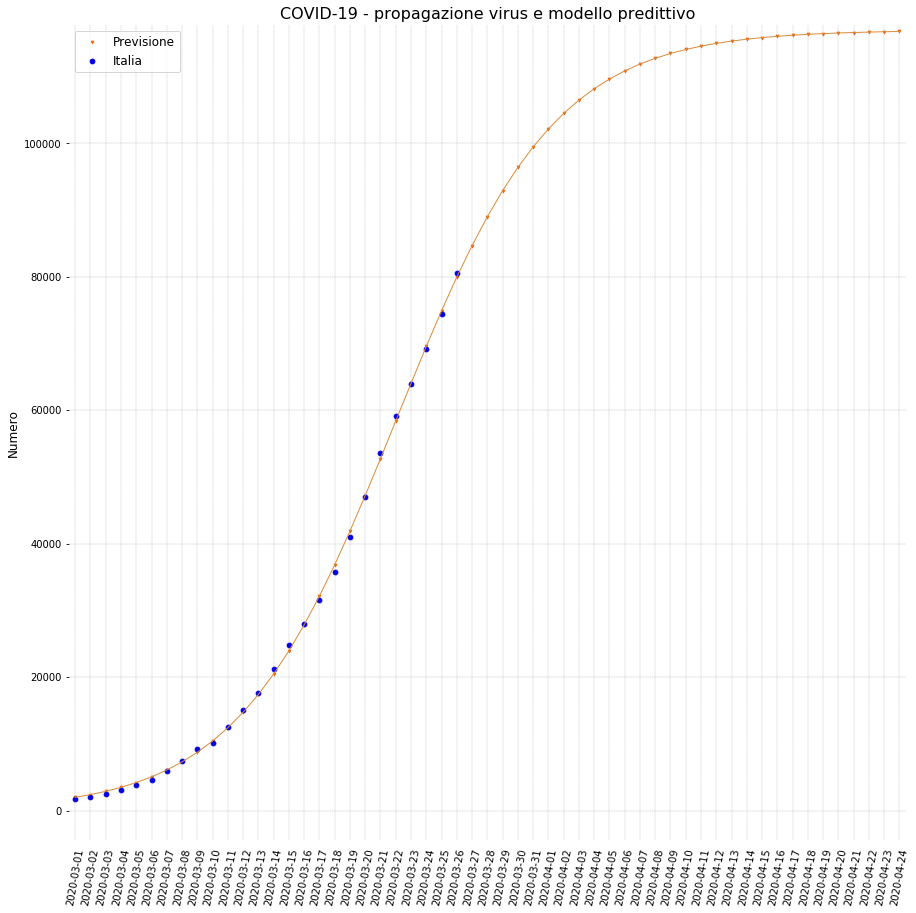

In [14]:
# ------------------------------------------------------
# Data preparation
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df["timeStamp"].min().strftime(date_format)
max_date = df["timeStamp"].max().strftime(date_format)
total = f'{df["Totale"].max():n}'

prediction_days = 30

x_index = list(df.columns).index('TimeDelta')
x_model = list(df.iloc[:,x_index])

max_x = df.iloc[:,x_index].max()
x_model = list(df.iloc[:,x_index]) + list(range(max_x + 1, max_x + prediction_days))
y_model = [logistic_model(i,it_log_fit[0][0],it_log_fit[0][1],it_log_fit[0][2]) for i in x_model]

df_prediction = df.copy()

begin = df.index.max()

for idx in range(1, prediction_days):
    df_prediction.loc[begin + idx] = None
    df_prediction.loc[begin + idx, "timeStamp"] = df["timeStamp"].max() + np.timedelta64(idx,'D')

print(str(len(x_model))+" "+str(df_prediction.shape))
    

df_dict = {
     "timeStamp": df_prediction["timeStamp"].values
    ,"Totale": y_model
}
df_model = pd.DataFrame(df_dict)

data_sets = {
    "Logistic": {
        "df": df_model,
        "label": "Previsione",
        "colors": ["#f06810", "#db8c3c"],
        "size": 7,
        "dot-shape": "v",
        "line-size": 1,
        "no_plot": False
    },
    "Italy": {
        "df": df_prediction,
        "label": "Italia",
        "colors": ["#0000e6", "#727170"],
        "size": 90,
        "dot-shape": ".",
        "line-size": 2.3,
        "no_plot": True
    }
}
# ------------------------------------------------------
# Chart
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(1, 1
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5) 

ax = []
ax.append(fig.add_subplot(gs1[0,0]))

idx = 0
x = df_lo["timeStamp"].dt.to_pydatetime()
composed_c_virus_chart(ax[idx], data_sets, title="COVID-19 - propagazione virus e modello predittivo")

plt.savefig(os.path.join(images_path,"covid19_IT_with_logistic_model_chart.png"))


In [15]:
df_model.head(30)

,timeStamp,Totale
0,2020-03-01,1971.074838
1,2020-03-02,2383.196005
2,2020-03-03,2879.327017
3,2020-03-04,3475.608027
4,2020-03-05,4190.835475
5,2020-03-06,5046.698621
6,2020-03-07,6067.940464
7,2020-03-08,7282.387533
8,2020-03-09,8720.775184
9,2020-03-10,10416.276980
